In [1]:
#connect google driver
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import tensorflow as tf
import numpy as np
import os
import PIL
import PIL.Image
import tensorflow_datasets as tfds


In [ ]:
print(tf.__version__)

2.14.0


In [2]:
import os

# Specify your dataset folder
dataset_folder = '/content/drive/MyDrive/Inflammatory Skin condition'

# Specify your classes
classes = ['Akne', 'Ekzema','Normal_skin']

# Function to rename images class-wise
def rename_images_classwise(folder, class_name):
    class_path = os.path.join(dataset_folder, class_name)
    images = os.listdir(class_path)

    for i, image in enumerate(images, start=1):
        # Specify the new name
        new_name = f"{class_name}{i}.jpg"

        # Rename the image
        old_path = os.path.join(class_path, image)
        new_path = os.path.join(class_path, new_name)
        os.rename(old_path, new_path)

# Rename images for each class
for class_name in classes:
    rename_images_classwise(dataset_folder, class_name)


In [10]:
import os
import pandas as pd
from sklearn.model_selection import train_test_split

# Path to the root folder of your dataset
data_path = '/content/drive/MyDrive/Inflammatory Skin condition'

# List all image files and their labels
all_images = []
all_labels = []

for label in os.listdir(data_path):
    label_path = os.path.join(data_path, label)
    if os.path.isdir(label_path):
        for image in os.listdir(label_path):
            all_images.append(os.path.join(label_path, image))
            all_labels.append(label)

# Check if the dataset has sufficient samples
if len(all_images) < 2:
    raise ValueError("Insufficient data for train-test split.")

# Split the dataset
train_images, test_val_images, train_labels, test_val_labels = train_test_split(
    all_images, all_labels, test_size=0.2, random_state=32
)
val_images, test_images, val_labels, test_labels = train_test_split(
    test_val_images, test_val_labels, test_size=0.5, random_state=32
)

# Create dataframes
train_df = pd.DataFrame({'image': train_images, 'label': train_labels})
val_df = pd.DataFrame({'image': val_images, 'label': val_labels})
test_df = pd.DataFrame({'image': test_images, 'label': test_labels})

# Save dataframes to CSV files
train_df.to_csv('/content/drive/MyDrive/check_pretrain/train.csv', index=False)
val_df.to_csv('/content/drive/MyDrive/check_pretrain/validation.csv', index=False)
test_df.to_csv('/content/drive/MyDrive/check_pretrain/test.csv', index=False)


In [18]:
# Data Augmentation and Loading with TensorFlow
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Image data generator with augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

# Define data generators
batch_size = 32

train_generator = train_datagen.flow_from_dataframe(
    train_df,
    x_col='image',
    y_col='label',
    target_size=(224, 224),
    batch_size=batch_size,
    class_mode='categorical'  # for multi-class classification
)

val_generator = val_datagen.flow_from_dataframe(
    val_df,
    x_col='image',
    y_col='label',
    target_size=(224, 224),
    batch_size=batch_size,
    class_mode='categorical'
)

test_generator = test_datagen.flow_from_dataframe(
    test_df,
    x_col='image',
    y_col='label',
    target_size=(224, 224),
    batch_size=batch_size,
    class_mode='categorical'
)


Found 4097 validated image filenames belonging to 3 classes.
Found 512 validated image filenames belonging to 3 classes.
Found 513 validated image filenames belonging to 3 classes.


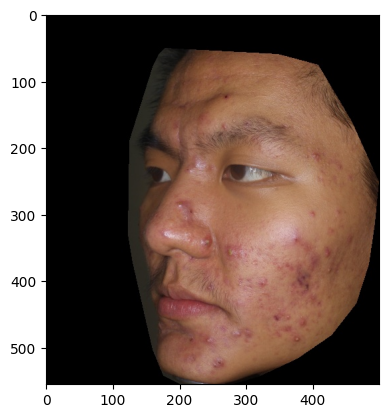

In [22]:
# Check image
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt

# Load an image using PIL (Python Imaging Library)
img_path = '/content/drive/MyDrive/Inflammatory Skin condition/Akne/Akne1563.jpg'
img = Image.open(img_path)

# Display the image using Matplotlib
plt.imshow(img)
plt.show()


In [ ]:
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Number of augmented images to visualize
num_images_to_visualize = min(5, val_generator.samples)

# Generate augmented images
augmented_images = val_generator.next()

# Visualize the original and augmented images
fig, axes = plt.subplots(2, num_images_to_visualize, figsize=(15, 5))

# Original images
for i in range(num_images_to_visualize):
    axes[0, i].imshow(augmented_images[0][i])
    axes[0, i].axis('on')
    axes[0, i].set_title('Original')

# Augmented images
for i in range(num_images_to_visualize):
    axes[1, i].imshow(augmented_images[0][i])
    axes[1, i].axis('on')
    axes[1, i].set_title('Augmented')

plt.show()


In [23]:
#count dataset
import os

dataset_path = '/content/drive/MyDrive/Inflammatory Skin condition/Ekzema'

# List all image files
image_files = [f for f in os.listdir(dataset_path) if f.endswith(('.jpg', '.jpeg', '.png'))]

# Count the number of images
num_images = len(image_files)

# Print the result
print(f'Total number of images: {num_images}')

Total number of images: 3000


In [24]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.models import Model

# Load VGG16 with pre-trained weights
base_model = VGG16(input_shape=(224, 224, 3), include_top=False, weights='imagenet')

# Freeze convolutional layers
for layer in base_model.layers:
    layer.trainable = False

# Add custom classification head
x = GlobalAveragePooling2D()(base_model.output)
x = Dense(1024, activation='relu')(x)
output = Dense(3, activation='softmax')(x)

# Create the model
model = Model(base_model.input, output)

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Display model summary
model.summary()


Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0   

In [ ]:
# Train the model
history = model.fit(
    train_generator,
    epochs=20,  # Adjust as needed
    validation_data=val_generator,
    verbose=1
)


Epoch 1/20
 92/129 [====================>.........] - ETA: 10:33 - loss: 0.3592 - accuracy: 0.8342

In [ ]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()
